# Predict RUL with ML model


**NOTE:** Before starting exploring this notebook, I strongly suggest checking the previous notebooks:

1. `1-EDA.ipynb` - contains some Exploratory Data Analysis of the datasets

2. `2-target-metrics-baseline.ipynb` - details about the target, evaluation metrics and a baseline model

3. `3-features-engineering.ipynb` - details about features engineering

**Table of Contents:**

1. Recap on the Baseline Model performance
2. Details about Cross-Validation and Testing
3. Poisson Regression:
    * with no features engineering
    * with TSfresh features
4. NGBoost
    * with TSfresh features
    * Performance on the Test set
    * Prognostics Metrics
5. Model with ROCKET features

In [1]:
# For being able to use the features engineering pipelines from `3-features_engineering.ipynb`,
# convert the `3-features_engineering.ipynb` notebook to python script 
!jupyter nbconvert 3-features_engineering.ipynb --to script --output features_engineering --TagRemovePreprocessor.remove_cell_tags='{"remove"}'


[NbConvertApp] Converting notebook 3-features_engineering.ipynb to script
[NbConvertApp] Writing 11787 bytes to features_engineering.py


In [2]:
!jupyter nbconvert 2-target-metrics-baseline.ipynb --to script --output target_metrics_baseline --TagRemovePreprocessor.remove_cell_tags='{"remove"}'


[NbConvertApp] Converting notebook 2-target-metrics-baseline.ipynb to script
[NbConvertApp] Writing 9588 bytes to target_metrics_baseline.py


In [3]:
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import read_dataset

%matplotlib inline

In [4]:
train, test, test_rul = read_dataset('FD001')

print('train:', train.shape)
print('test:', test.shape)
train.head(2)

train: (20631, 26)
test: (13096, 26)


,unit,time_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236


## Baseline Model

As we saw in the `2-target-metrics-baseline.ipynb` notebook, the baseline model scored the following values on the test set (FD001 dataset):

```
{
    'rmse': 36.63836786757838,
    'mae': 31.37,
    'mape': 0.906682116160513,
    'score': 7657.158284814168
}
```

Now we treat this as a reference for further experiments with models. 

## Cross-validation and Testing

One important aspect in our cross-validation procedure is that the same engine will not appear in 2 different folds, meaning that a model can see some engine's all the data either during training or validation. For this kind of cross-validation we are using a scikit-learn method **`GroupKFold`**, where our groups are engines IDs. An example of cross-validation with `sklearn.model_selection.GroupKFold` is visualized below:

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_005.png)

*Figure source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py*

Note that ignoring this kind of cross-validation and using a standart KFold cross-validation without considering engines as groups - causes a data leakage (during a validation your model has already seen this engine during training).



As we saw in `2-target-metrics-baseline.ipynb` notebook, distributions of train and test Remaining Useful Life differ, which might lead to cross-validation results not aligning well with performance on the test set. We try to alter validation sets to limit its ranges according to the test set: 

In [5]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_validate

In [6]:
class CustomGroupKFold(GroupKFold):
    '''
    CV Splitter which drops validation records with 
    RUL values outside of test set RULs ranges
    '''
    def split(self, X, y, groups):
        splits = super().split(X, y, groups)

        for train_ind, val_ind in splits:
            yield train_ind, val_ind[(y[val_ind] > 6) & (y[val_ind] < 135)]

In [7]:
def evaluate(model, X, y, groups, cv, 
             scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'], 
             n_jobs=None, 
             verbose=False):
    '''
    Evaluate a model with Cross-Validation
    '''
    cv_results = cross_validate(
        model, 
        X=X,
        y=y,
        groups=groups,
        scoring=scoring,
        cv=cv,
        return_train_score=True,
        return_estimator=True,
        n_jobs=n_jobs,
        verbose=verbose
    )
    
    for k, v in cv_results.items():
        if k.startswith('train_') or k.startswith('test_'):
            k_sp = k.split('_')
            print(f'[{k_sp[0]}] :: {" ".join(k_sp[2:])} : {np.abs(v.mean()):.2f} +- {v.std():.2f}')
    return cv_results

When testing model on a test set, we treat the model's prediction on the last available time step as a final prediction. The function below evaluates a model on a test set comparing the last predictions from every engine with the true RUL values: 

In [8]:
from target_metrics_baseline import plot_residuals_vs_actual
from target_metrics_baseline import rul_metrics_scorer

In [9]:
def test_model(model, X_test, engines, test_rul, plot_figures=False, **plot_kwargs):
    '''Evaluate on a test set'''
    X_test_last = X_test.groupby(engines, as_index=False).last()

    if plot_figures:
        pred_rul = model.predict(X_test_last.values)
        plot_residuals_vs_actual(test_rul, pred_rul, **plot_kwargs)

    return rul_metrics_scorer(model, X_test_last.values, test_rul, metrics='all')

# Linear Model

We would like to start with a simple model using the original data without features engineering, that should also give us some reference for further modeling.

A couple of important comments here:

* our targets are non-negative integers

* models that assume normal distribution of target, e.g. linear regression, can output negative predictions. 

    * if use such models, you have to transform your target - for instance, log transform and inverse transform with exponential (we'll do that later in section with ROCKET features)

* our observations are not independent of each other

Poisson regression might be a good option here. First we train the model on the original data:

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import PoissonRegressor
from sklearn.compose import make_column_selector

from target_metrics_baseline import calculate_RUL

In [11]:
RUL_THRESHOLD = 135

In [12]:
get_ftr_names = make_column_selector(pattern='sensor')

model = Pipeline([
    ('scale', StandardScaler()),
    ('model', PoissonRegressor(alpha=0.1))
])

cv_result = evaluate(
    model,
    X=train[get_ftr_names(train)].values, 
    y=calculate_RUL(train, upper_threshold=RUL_THRESHOLD), 
    groups=train['unit'], 
    cv=CustomGroupKFold(n_splits=5)
)

[test] :: root mean squared error : 23.16 +- 2.25
[train] :: root mean squared error : 25.98 +- 0.48
[test] :: mean absolute error : 18.52 +- 2.22
[train] :: mean absolute error : 21.06 +- 0.51


Now we would like to apply our preprocessing steps and try the same model:

In [13]:
from features_engineering import LowVarianceFeaturesRemover, ScalePerEngine
from utils import SENSOR_COLUMNS

In [14]:
preprocess_pipe = Pipeline([
    # Cleaning constant features
    ('drop-low-variance', LowVarianceFeaturesRemover(threshold=0)),
    
    # Scaling sensors values
    ('scale-per-engine', ScalePerEngine(n_first_cycles=15, sensors_columns=SENSOR_COLUMNS)),
])

train_sc = preprocess_pipe.fit_transform(train)

Droped low variance features: ['op_setting_3', 'sensor_1', 'sensor_5', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']


In [15]:
model = Pipeline([
    ('scale', StandardScaler()),
    ('model', PoissonRegressor(alpha=0.1))
])

cv_result = evaluate(
    model, 
    X=train_sc[get_ftr_names(train_sc)].values, 
    y=calculate_RUL(train_sc, upper_threshold=RUL_THRESHOLD), 
    groups=train_sc['unit'], 
    cv=CustomGroupKFold(n_splits=5)
)

[test] :: root mean squared error : 19.18 +- 0.79
[train] :: root mean squared error : 19.63 +- 0.11
[test] :: mean absolute error : 15.00 +- 0.61
[train] :: mean absolute error : 15.40 +- 0.11


So, only the preprocessing significantly improves the performance.

<br>

## Poisson Regression with TSfresh Features

Here we use the features engineering pipeline we've prepared in `3-features_engineering.ipynb` notebook. 

We would like to incorporate features values from both long and short time ranges. There're two pipelines:

1. the first one aggregates data into windows of length 20, calculates PCA on top of TSFresh features and select top components. 

2. the other pipeline aggregates data into windows of length 5, and calculates averages


In [16]:
from features_engineering import (RollTimeSeries, TSFreshFeaturesExtractor, 
                                  CustomPCA, TSFreshFeaturesSelector, tsfresh_calc)

In [17]:
features_long_h_pipe = Pipeline([
    # Cleaning
    ('drop-low-variance', LowVarianceFeaturesRemover(threshold=0)),
    
    # Scaling and Preprocessing
    ('scale-per-engine', ScalePerEngine(n_first_cycles=10, sensors_columns=SENSOR_COLUMNS)),
    ('roll-time-series', RollTimeSeries(min_timeshift=19, max_timeshift=19, rolling_direction=1)),
    
    # TSFresh features engineering
    ('extract-tsfresh-features', TSFreshFeaturesExtractor(calc=tsfresh_calc)),
    ('PCA', CustomPCA(n_components=20)),
    ('features-selection', TSFreshFeaturesSelector(fdr_level=0.001)),
])


features_short_h_pipe = Pipeline([
    # Cleaning
    ('drop-low-variance', LowVarianceFeaturesRemover(threshold=0)),
    
    # Scaling and Preprocessing
    ('scale-per-engine', ScalePerEngine(n_first_cycles=10, sensors_columns=SENSOR_COLUMNS)),
    ('roll-time-series', RollTimeSeries(min_timeshift=4, max_timeshift=4, rolling_direction=1)),
    
    # TSFresh features engineering
    ('extract-tsfresh-features', TSFreshFeaturesExtractor(calc={'mean': None})),
    ('features-selection', TSFreshFeaturesSelector(fdr_level=0.0002)),
])

In [18]:
train_long_h_ftrs = features_long_h_pipe.fit_transform(train)

Droped low variance features: ['op_setting_3', 'sensor_1', 'sensor_5', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
Start Rolling TS


Rolling: 100%|███████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.97it/s]


Done Rolling TS in 0:00:10.641048
Start Extracting Features


Feature Extraction: 100%|████████████████████████████████████████████████████████| 20/20 [09:50<00:00, 29.53s/it]


Done Extracting Features in 0:10:29.755486
Droped 19 duplicate features
Droped 11 features with NA values
Selected 9 out of 20 features: [0, 3, 2, 4, 1, 5, 15, 8, 7]


In [19]:
train_short_h_ftrs = features_short_h_pipe.fit_transform(train)

Droped low variance features: ['op_setting_3', 'sensor_1', 'sensor_5', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
Start Rolling TS


Rolling: 100%|███████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.04it/s]


Done Rolling TS in 0:00:10.091054
Start Extracting Features


Feature Extraction: 100%|████████████████████████████████████████████████████████| 20/20 [00:41<00:00,  2.06s/it]


Done Extracting Features in 0:00:42.012816
Droped 0 duplicate features
Droped 0 features with NA values
Selected 15 out of 15 features: ['sensor_2__mean', 'sensor_3__mean', 'sensor_4__mean', 'sensor_7__mean', 'sensor_8__mean', 'sensor_9__mean', 'sensor_11__mean', 'sensor_12__mean', 'sensor_13__mean', 'sensor_15__mean', 'sensor_17__mean', 'sensor_20__mean', 'sensor_21__mean', 'sensor_14__mean', 'sensor_6__mean']


<br>

Next, we merge the two features sets:

In [20]:
train_ftrs = train_long_h_ftrs.merge(train_short_h_ftrs, how='inner', right_index=True, left_index=True)
train_ftrs.index = train_ftrs.index.set_names(['unit', 'time_cycles'])

print('train_ftrs: ', train_ftrs.shape)
train_ftrs.head(2)

train_ftrs:  (17731, 24)


0         3         2         4         1         5  \
unit time_cycles                                                               
1.0  30.0        -9.568131  5.146442 -1.968338  0.107544 -1.212925  0.627717   
     31.0        -9.585286  5.188447 -1.794828  0.308190 -1.200702  1.648585   

                        15         8         7  sensor_2__mean  ...  \
unit time_cycles                                                ...   
1.0  30.0        -1.183936 -1.884038 -4.026666           0.011  ...   
     31.0        -1.478099 -2.075823 -3.026157          -0.017  ...   

                  sensor_9__mean  sensor_11__mean  sensor_12__mean  \
unit time_cycles                                                     
1.0  30.0                 -1.360            0.064            0.144   
     31.0                  0.974            0.094            0.078   

                  sensor_13__mean  sensor_15__mean  sensor_17__mean  \
unit time_cycles                                                      
1.0  30.0                   0.022          0.00927              0.2   
     31.0                   0.022          0.00615             -0.2   

                  sensor_20__mean  sensor_21__mean  sensor_14__mean  \
unit time_cycles                                                      
1.0  30.0           -1.600000e-02         -0.00622            0.566   
     31.0           -2.842171e-15         -0.02214           -0.608   

                  sensor_6__mean  
unit time_cycles                  
1.0  30.0          -3.552714e-15  
     31.0          -3.552714e-15  

[2 rows x 24 columns]

In [21]:
X_train = train_ftrs.reset_index().drop(columns=['unit'])

train_units_df = train_ftrs.index.to_frame(index=False)
y_train = calculate_RUL(train_units_df, upper_threshold=RUL_THRESHOLD)

In [22]:
model = Pipeline([
    ('scale', StandardScaler()),
    ('model', PoissonRegressor(alpha=0.01))
])

cv_res = evaluate(
    model, 
    X=X_train.values, 
    y=y_train, 
    groups=train_units_df['unit'], 
    cv=CustomGroupKFold(n_splits=5)
)

[test] :: root mean squared error : 13.89 +- 1.12
[train] :: root mean squared error : 14.13 +- 0.19
[test] :: mean absolute error : 10.94 +- 0.83
[train] :: mean absolute error : 11.11 +- 0.16


So, our features engineering pipeline significantly improves the model's performance - RMSE **13.89 vs 19.18** (from the previous experiment).

We could tune the pipelines parameters, but something to keep in mind is that the shortest lifetime in the test set (FD001) is 31 cycles - hence, should consider that when select, for instance, window length in the pipeline.

<br>


# NGBoost - Natural Gradient Boosting for Probabilistic Prediction

A problem of single point predictions is that **it provides no uncertainty estimates** of a given prediction. Usually, in real world use cases, uncetainties assosiated with a provided predictions might be of more importance then the predictions itself. There's a good example of problems that can happen when not considering this, in book of Nate Silver "The Signal and the Noise: Why So Many Predictions Fail-but Some Don't".

So, we would like to focus on methods able to provide **prediction intervals**.

NGBoost - an interesting algorithm which provides predictive uncertainty estimation to gradient boosting:

    https://stanfordmlgroup.github.io/projects/ngboost/

NGBoost model outputs a full probability distribution over the entire outcome space.

![](https://stanfordmlgroup.github.io/projects/ngboost/img/blocks.png)


First, we start with the default hyperparams. 

Note: with NGBoost, we get similar performance from using Poisson or LogNormal distributions.

In [23]:
from ngboost import NGBRegressor
from ngboost.distns import LogNormal, Poisson

In [24]:
ngb = NGBRegressor(Dist=Poisson)

cv_res = evaluate(
    ngb,
    X=X_train.values, 
    y=y_train, 
    groups=train_units_df['unit'], 
    cv=CustomGroupKFold(n_splits=4),
    n_jobs=4
)

[test] :: root mean squared error : 13.46 +- 0.50
[train] :: root mean squared error : 12.28 +- 0.14
[test] :: mean absolute error : 10.16 +- 0.45
[train] :: mean absolute error : 9.42 +- 0.10


We'd like to do a small hyperparams search, trying to change a base learner, minibatch fraction and ratio of features to sample:

In [25]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [27]:
param_grid = {
    'Base': [
        DecisionTreeRegressor(criterion='friedman_mse', max_depth=4),
        DecisionTreeRegressor(criterion='friedman_mse', max_depth=5, max_features=0.8, min_samples_split=50),
    ],
    'minibatch_frac': [1, 0.8, 0.5],
}


ngb = NGBRegressor(Dist=Poisson, learning_rate=0.02, n_estimators=500, verbose=False)

grid_search = GridSearchCV(
    ngb,
    scoring='neg_root_mean_squared_error',
    param_grid=param_grid, 
    cv=CustomGroupKFold(n_splits=4),
    n_jobs=6
)

# excluding 0 RUL values seems to do better
grid_search.fit(X_train[y_train > 0].values, 
                y_train[y_train > 0], 
                groups=train_units_df[y_train > 0]['unit'])


GridSearchCV(cv=CustomGroupKFold(n_splits=4),
             estimator=NGBRegressor(Dist=<class 'ngboost.distns.poisson.Poisson'>,
                                    learning_rate=0.02,
                                    random_state=RandomState(MT19937) at 0x1143D0240,
                                    verbose=False),
             n_jobs=6,
             param_grid={'Base': [DecisionTreeRegressor(criterion='friedman_mse',
                                                        max_depth=4),
                                  DecisionTreeRegressor(criterion='friedman_mse',
                                                        max_depth=5,
                                                        max_features=0.8,
                                                        min_samples_split=50)],
                         'minibatch_frac': [1, 0.8, 0.5]},
             scoring='neg_root_mean_squared_error')

In [28]:
ngb_base = DecisionTreeRegressor(criterion='friedman_mse', max_depth=5, max_features=0.8, min_samples_leaf=50)
ngb = NGBRegressor(Dist=Poisson, Base=ngb_base, learning_rate=0.01, 
                   col_sample=0.8, minibatch_frac=0.5, n_estimators=400)

cv_res = evaluate(
    ngb,
    X=X_train[y_train > 0].values, 
    y=y_train[y_train > 0], 
    groups=train_units_df[y_train > 0]['unit'], 
    cv=CustomGroupKFold(n_splits=4),
    n_jobs=4
)

[test] :: root mean squared error : 12.74 +- 0.19
[train] :: root mean squared error : 9.98 +- 0.06
[test] :: mean absolute error : 9.52 +- 0.28
[train] :: mean absolute error : 7.31 +- 0.05


ok, it gave us improvement by -1 in RMSE compared to the Poisson Regression.

We can now check the features importances - let's consider average of features importances from cross-validation iterations:

In [29]:
ftr_importance = pd.DataFrame()
for i, cv_estimator in enumerate(cv_res['estimator']):
    ftr_importance = ftr_importance.append(
        pd.DataFrame({
        'cv_iter': i,
        'feature': X_train.columns,
        'importance': cv_estimator.feature_importances_.reshape(-1).round(5)
        }),
        ignore_index=True
    )

ftr_importance_agg = (ftr_importance
    .groupby('feature')['importance']
    .agg(['mean', 'std'])
    .sort_values('mean', ascending=False)
    .reset_index()
)

ftr_importance_agg

,feature,mean,std
0,0,0.328988,0.015712
1,sensor_4__mean,0.101210,0.021006
2,sensor_11__mean,0.074610,0.018754
3,sensor_15__mean,0.067865,0.013929
4,time_cycles,0.065010,0.004866
5,sensor_6__mean,0.049945,0.005634
6,sensor_21__mean,0.033975,0.021738
7,sensor_9__mean,0.029960,0.005762
8,3,0.026462,0.008760
9,sensor_20__mean,0.022042,0.013940


As expected, the first principal component from tsfresh features calculated on a longer cycles window got the highest importance with a big gap from the next less important feature. However, all the rest principal components seem to be of little importance.

We can try ignoring the least important features:

In [30]:
drop_features = ftr_importance_agg['feature'].iloc[-6:].values
drop_features

array(['sensor_7__mean', 'sensor_8__mean', 'sensor_2__mean', 15,
       'sensor_13__mean', 'sensor_17__mean'], dtype=object)

In [31]:
SELECTED_FEATURES = ftr_importance_agg['feature'].iloc[:-6].values
SELECTED_FEATURES

array([0, 'sensor_4__mean', 'sensor_11__mean', 'sensor_15__mean',
       'time_cycles', 'sensor_6__mean', 'sensor_21__mean',
       'sensor_9__mean', 3, 'sensor_20__mean', 'sensor_14__mean', 2, 1,
       'sensor_3__mean', 8, 'sensor_12__mean', 4, 7, 5], dtype=object)

In [32]:
ngb_base = DecisionTreeRegressor(criterion='friedman_mse', max_depth=5, max_features=0.8, min_samples_leaf=50)
ngb = NGBRegressor(Dist=Poisson, Base=ngb_base, learning_rate=0.01, 
                   col_sample=0.8, minibatch_frac=0.5, n_estimators=400, verbose=False)

cv_res = evaluate(
    ngb,
    X=X_train[SELECTED_FEATURES][y_train > 0].values, 
    y=y_train[y_train > 0], 
    groups=train_units_df[y_train > 0]['unit'], 
    cv=CustomGroupKFold(n_splits=4),
    n_jobs=4
)

[test] :: root mean squared error : 12.83 +- 0.12
[train] :: root mean squared error : 10.08 +- 0.10
[test] :: mean absolute error : 9.54 +- 0.23
[train] :: mean absolute error : 7.39 +- 0.07


Droping the least important features didn't hurt the performance scores.

## Evaluate on a test set

Before testing the model on a corresponding test set - we train the model on a whole train set:

In [33]:
ngb.fit(X_train[SELECTED_FEATURES][y_train > 0].values, y_train[y_train > 0])

NGBRegressor(Base=DecisionTreeRegressor(criterion='friedman_mse', max_depth=5,
                                        max_features=0.8, min_samples_leaf=50),
             Dist=<class 'ngboost.distns.poisson.Poisson'>, col_sample=0.8,
             minibatch_frac=0.5, n_estimators=400,
             random_state=RandomState(MT19937) at 0x1143D0240, verbose=False)

Now, let's transform the test dataset with the features engineerings pipelines:

In [35]:
test_long_h_fts = features_long_h_pipe.transform(test)
test_short_h_fts = features_short_h_pipe.transform(test)

test_ftrs = test_long_h_fts.merge(test_short_h_fts, how='inner', right_index=True, left_index=True)
test_ftrs.index = test_ftrs.index.set_names(['unit', 'time_cycles'])

X_test = test_ftrs.reset_index().drop(columns=['unit'])
test_units = test_ftrs.index.to_frame(index=False)

print('test_ftrs: ', test_ftrs.shape)

Droped low variance features: ['op_setting_3', 'sensor_1', 'sensor_5', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
Start Rolling TS


Rolling: 100%|███████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.66it/s]


Done Rolling TS in 0:00:07.852916
Start Extracting Features


Feature Extraction: 100%|████████████████████████████████████████████████████████| 20/20 [06:18<00:00, 18.90s/it]


Done Extracting Features in 0:06:38.372006
Droped 19 duplicate features
Droped 11 features with NA values
Droped low variance features: ['op_setting_3', 'sensor_1', 'sensor_5', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
Start Rolling TS


Rolling: 100%|███████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.34it/s]


Done Rolling TS in 0:00:08.764242
Start Extracting Features


Feature Extraction: 100%|████████████████████████████████████████████████████████| 20/20 [00:28<00:00,  1.41s/it]


Done Extracting Features in 0:00:28.708746
Droped 0 duplicate features
Droped 0 features with NA values
test_ftrs:  (10196, 24)


And test the model:

{'rmse': 12.566215463825678,
 'mae': 9.501043836917312,
 'mape': 0.17223164959127543,
 'score': 285.51330543211714}

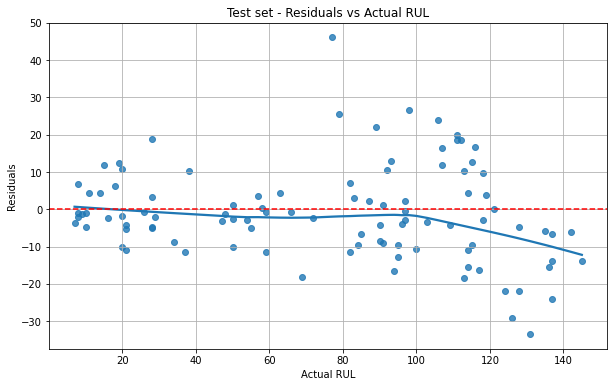

In [38]:
test_model(ngb, X_test[SELECTED_FEATURES], test_units['unit'], test_rul, plot_figures=True)

Looks good, except the right side, where engines with the highest actual RUL - the model underestimates their Remaining Useful Life.

## Prognostics Metrics

Let's also evaluate the model with the prognostics metrics described in `2-target-metrics-baseline.ipynb`.

We sample 10 engines for validation set to be evaluated with the prognostics metrics, and we retrain the model on all the rest engines data.

In [39]:
np.random.seed(2021)
validation_units = np.random.choice(train_units_df['unit'].unique(), size=10, replace=False)
validation_units

array([90.,  3., 47.,  5., 78.,  9., 33., 23., 14., 61.])

In [40]:
X_train_sample = X_train[~train_units_df['unit'].isin(validation_units)]
y_train_sample = y_train[~train_units_df['unit'].isin(validation_units)]

ngb = NGBRegressor(Dist=Poisson, Base=ngb_base, learning_rate=0.01, 
                   col_sample=0.8, minibatch_frac=0.5, n_estimators=400, verbose=False)
ngb.fit(
    X_train_sample[SELECTED_FEATURES][y_train_sample > 0].values, 
    y_train_sample[y_train_sample > 0]
)

NGBRegressor(Base=DecisionTreeRegressor(criterion='friedman_mse', max_depth=5,
                                        max_features=0.8, min_samples_leaf=50),
             Dist=<class 'ngboost.distns.poisson.Poisson'>, col_sample=0.8,
             minibatch_frac=0.5, n_estimators=400,
             random_state=RandomState(MT19937) at 0x1143D0240, verbose=False)

NGboost model has method `pred_dist` which predicts conditional distribution of Y given X. We will plot prediction intervals as 95th and 5th percentiles of the predicted distributions.

In [41]:
from target_metrics_baseline import prognostic_horizon, alpha_lambda_acc, relative_accuracy

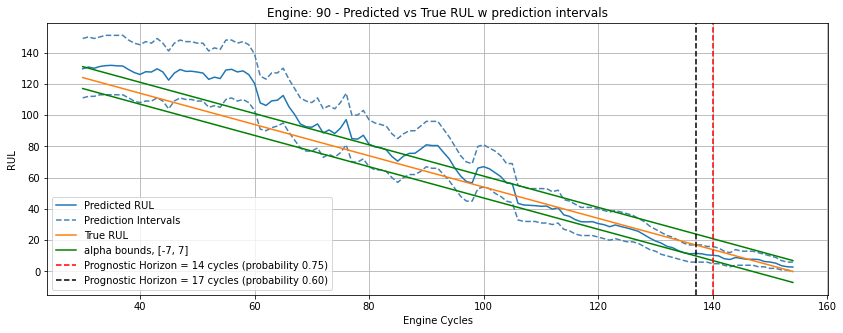

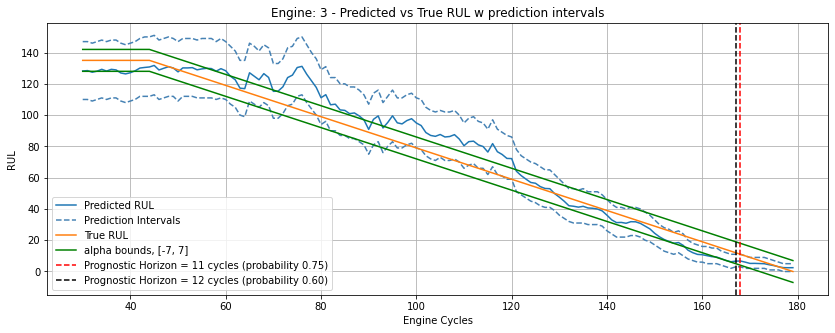

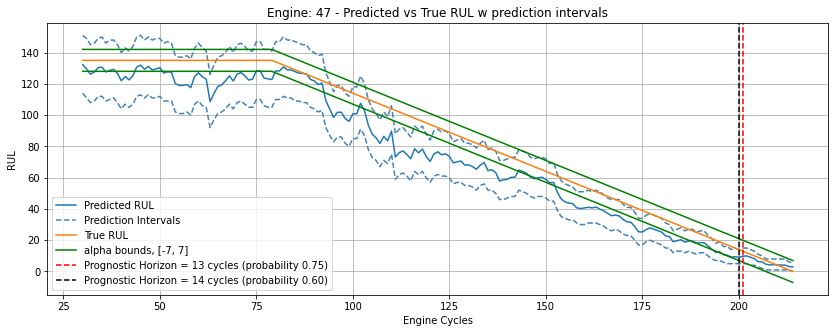

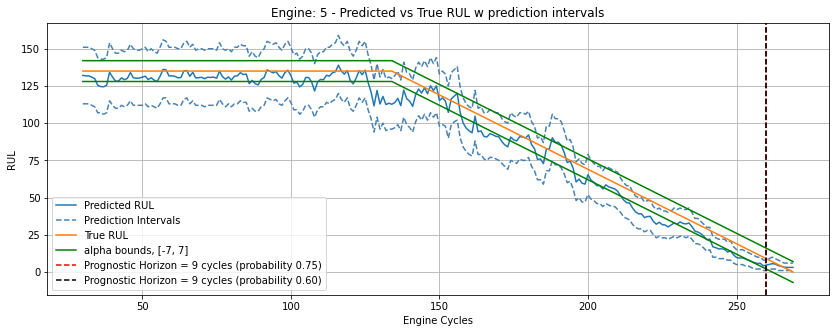

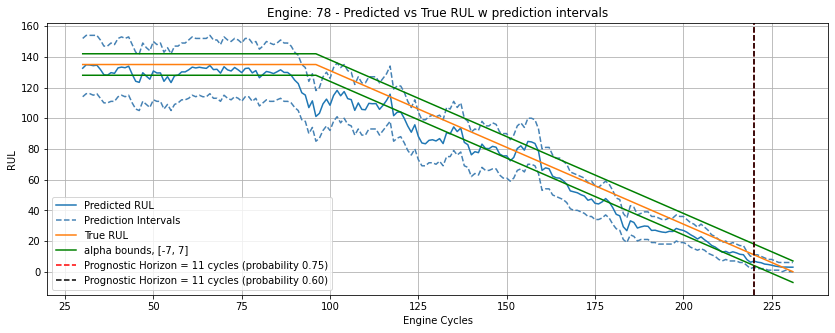

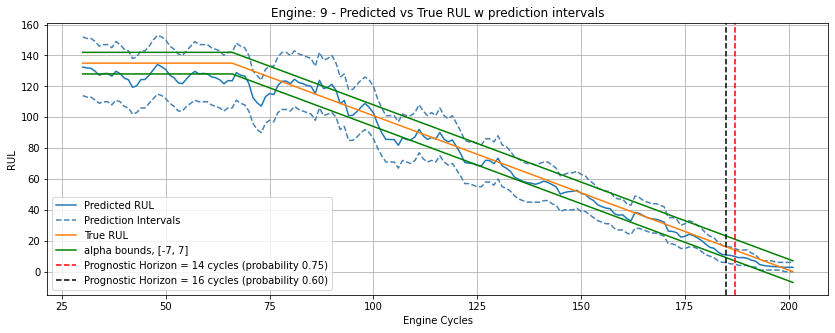

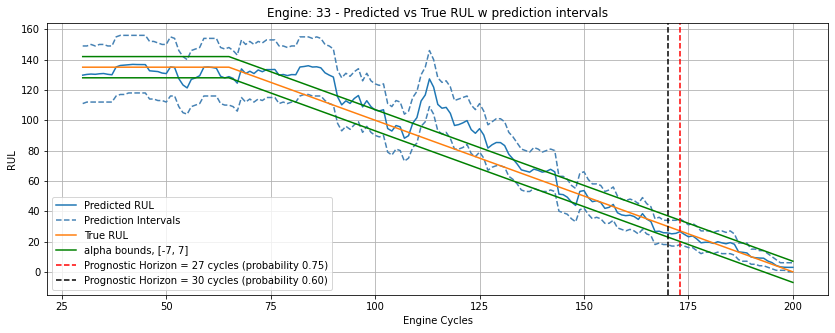

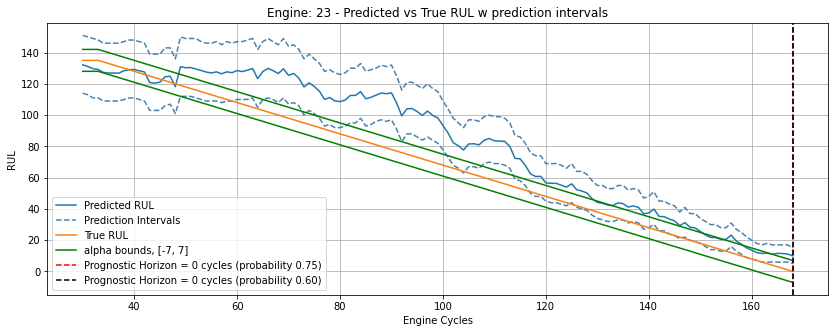

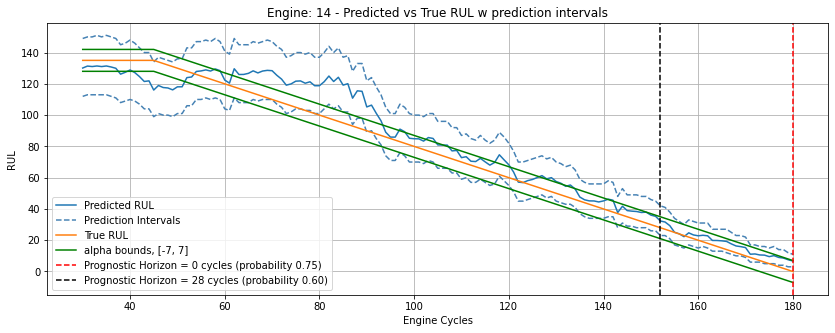

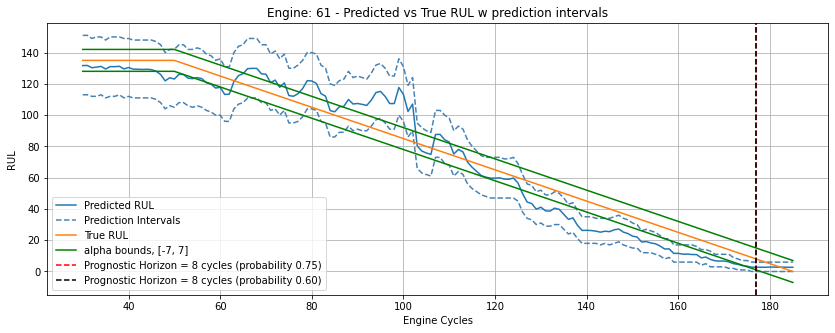

In [42]:
pr_hoziron_df = pd.DataFrame()

for val_unit in validation_units:
    val_unit_df = X_train[train_units_df['unit'] == val_unit]
    val_unit_rul = calculate_RUL(train_units_df[train_units_df['unit'] == val_unit], upper_threshold=135)

    predicted_rul = ngb.predict(val_unit_df[SELECTED_FEATURES].values)
    predicted_dist = ngb.pred_dist(val_unit_df[SELECTED_FEATURES].values)

    alphas = [-7, 7]
    pr_horizon_75, _ = prognostic_horizon(predicted_dist, val_unit_rul, beta=0.75, alphas=alphas)
    pr_horizon_60, _ = prognostic_horizon(predicted_dist, val_unit_rul, beta=0.60, alphas=alphas)

    pr_hoziron_df = pr_hoziron_df.append(
        pd.DataFrame([
            {'unit': val_unit, 'prognostic_horizon': pr_horizon_75, 'probability': 0.75, 'alpha': alphas},
            {'unit': val_unit, 'prognostic_horizon': pr_horizon_60, 'probability': 0.60, 'alpha': alphas}
        ]),
        ignore_index=True
    )

    plt.figure(figsize=(14, 5))
    plt.plot(val_unit_df['time_cycles'], predicted_rul, label='Predicted RUL')
    plt.plot(val_unit_df['time_cycles'], predicted_dist.dist.ppf(0.95), 
             linestyle='--', color='steelblue', label='Prediction Intervals')
    plt.plot(val_unit_df['time_cycles'], predicted_dist.dist.ppf(0.05), linestyle='--', color='steelblue')
    plt.plot(val_unit_df['time_cycles'], val_unit_rul, label='True RUL')
    plt.plot(val_unit_df['time_cycles'], val_unit_rul + alphas[1], color='green', label=f'alpha bounds, {alphas}')
    plt.plot(val_unit_df['time_cycles'], val_unit_rul + alphas[0], color='green')

    plt.axvline(x=val_unit_df['time_cycles'].values[::-1][pr_horizon_75], color='red', linestyle='--', 
                label=f'Prognostic Horizon = {pr_horizon_75} cycles (probability 0.75)')
    plt.axvline(x=val_unit_df['time_cycles'].values[::-1][pr_horizon_60], color='black', linestyle='--', 
                label=f'Prognostic Horizon = {pr_horizon_60} cycles (probability 0.60)')

    plt.legend()
    plt.grid()
    plt.title(f'Engine: {int(val_unit)} - Predicted vs True RUL w prediction intervals')
    plt.ylabel('RUL')
    plt.xlabel('Engine Cycles')
    plt.show()


Note how the algorithm converges as time reaches end of engines life.  

In [43]:
pr_hoziron_df

,unit,prognostic_horizon,probability,alpha
0,90.0,14,0.75,"[-7, 7]"
1,90.0,17,0.60,"[-7, 7]"
2,3.0,11,0.75,"[-7, 7]"
3,3.0,12,0.60,"[-7, 7]"
4,47.0,13,0.75,"[-7, 7]"
5,47.0,14,0.60,"[-7, 7]"
6,5.0,9,0.75,"[-7, 7]"
7,5.0,9,0.60,"[-7, 7]"
8,78.0,11,0.75,"[-7, 7]"
9,78.0,11,0.60,"[-7, 7]"


In [44]:
pr_hoziron_df.groupby('probability')['prognostic_horizon'].median()

probability
0.60    13
0.75    11
Name: prognostic_horizon, dtype: int64

We got an average Prognostic Horizon of `11` cycles for probability `75%` and error margins `[-7, 7]` cycles.

Also, we can calculate Alpha-Lambda Accuracy and Relative Accuracy at different time instances $t_{\lambda}$ of the validation engines. Time instance $t_{\lambda}$ can be defined as a fraction of engines lifetime - $\lambda$:

$$t_{\lambda} = t_{0} + \lambda * (t_{EOL} - t_{0}),$$

where
* $t_{EOL}$ engined End Of Life
* $t_{0}$ is a time instance of a first prediction made.


In [45]:
# lambda list
time_frac_list = [0.5, 0.75, 0.9, 0.95]

# probability threshold for alpha-lambda accuracy
beta_proba = 0.6
alpha = 0.3

In [46]:
alpha_lambda_df = pd.DataFrame()
for val_unit in validation_units:
    val_unit_df = X_train[train_units_df['unit'] == val_unit]
    val_unit_rul = calculate_RUL(train_units_df[train_units_df['unit'] == val_unit], upper_threshold=135)

    predicted_rul = ngb.predict(val_unit_df[SELECTED_FEATURES].values)
    predicted_dist = ngb.pred_dist(val_unit_df[SELECTED_FEATURES].values)

    alpha_lambda = alpha_lambda_acc(predicted_dist, val_unit_rul, 
                                    time_frac=time_frac_list, beta=beta_proba, alpha=alpha)
    relative_acc = relative_accuracy(predicted_rul, val_unit_rul, time_frac=time_frac_list)

    alpha_lambda_df = alpha_lambda_df.append(
        pd.DataFrame({'engine': val_unit, 
                      'time_frac': time_frac_list, 
                      'alpha_lambda': alpha_lambda[0], 
                      'alpha_lambda_probas': alpha_lambda[1],
                      'relative_acc': relative_acc
                     }), 
        ignore_index=True)


Alpha-Lambda Accuracy for different fractions of lifetime:

In [47]:
alpha_lambda_df.groupby('time_frac')['alpha_lambda'].mean()

time_frac
0.50    0.7
0.75    0.8
0.90    0.1
0.95    0.0
Name: alpha_lambda, dtype: float64

In [48]:
alpha_lambda_df.groupby('time_frac')['alpha_lambda_probas'].mean()

time_frac
0.50    0.798823
0.75    0.775378
0.90    0.341685
0.95    0.278634
Name: alpha_lambda_probas, dtype: float64

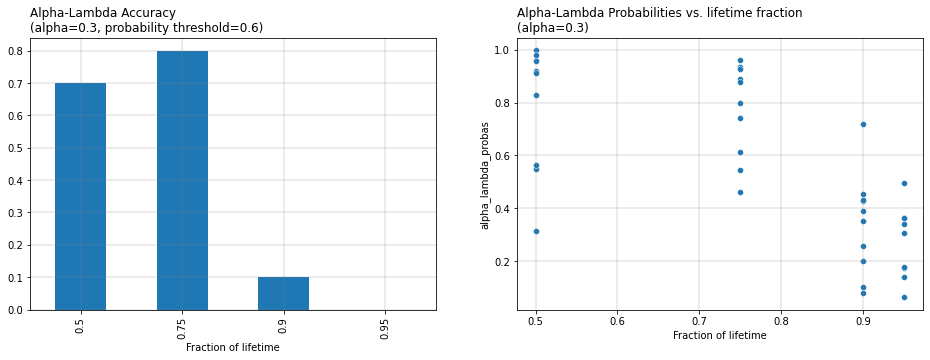

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

alpha_lambda_df.groupby('time_frac')['alpha_lambda'].mean().plot.bar(ax=ax[0])
ax[0].grid(color='grey', linewidth=0.3)
ax[0].set_title(f'Alpha-Lambda Accuracy \n(alpha={alpha}, probability threshold={beta_proba})', loc='left')
ax[0].set_xlabel('Fraction of lifetime')


sns.scatterplot(data=alpha_lambda_df, x='time_frac', y='alpha_lambda_probas', ax=ax[1])
ax[1].set_title(f'Alpha-Lambda Probabilities vs. lifetime fraction\n(alpha={alpha})', loc='left')
ax[1].grid(color='grey', linewidth=0.3)
ax[1].set_xlabel('Fraction of lifetime')

fig.show()

Average Relative Accuracy for different fractions of lifetime:

In [50]:
alpha_lambda_df.groupby('time_frac')['relative_acc'].mean()

time_frac
0.50    0.823602
0.75    0.845528
0.90    0.615596
0.95    0.579327
Name: relative_acc, dtype: float64

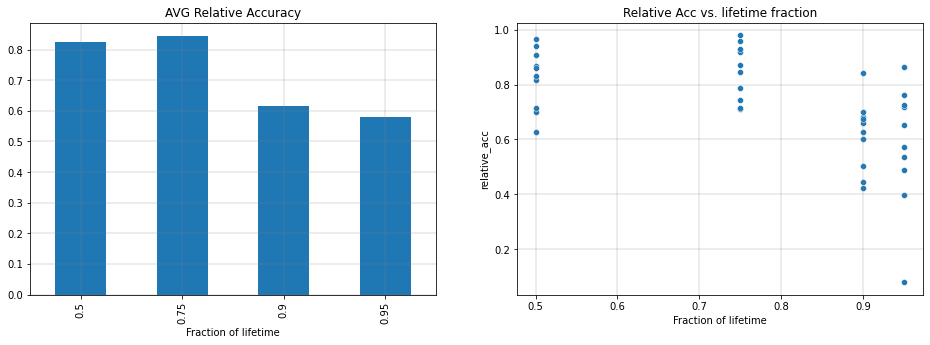

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

alpha_lambda_df.groupby('time_frac')['relative_acc'].mean().plot.bar(ax=ax[0])
ax[0].grid(color='grey', linewidth=0.3)
ax[0].set_title('AVG Relative Accuracy')
ax[0].set_xlabel('Fraction of lifetime')

sns.scatterplot(data=alpha_lambda_df, x='time_frac', y='relative_acc', ax=ax[1])
ax[1].set_title('Relative Acc vs. lifetime fraction')
ax[1].grid(color='grey', linewidth=0.3)
ax[1].set_xlabel('Fraction of lifetime')

fig.show()

We got low $\alpha-\lambda$ accuracy for $\lambda$ 0.9 and 0.95, but AVG Relative Accuracy for these time fractinos are 0.61 and 0.57 accordingly. 

Averall, in my opinion these metrics are useful in a way they account for **prediction uncertainties** and different **time instances of predictions**.

# Linear model with ROCKET features

We would like to try out train a model with the ROCKET features:

In [52]:
from features_engineering import (rocket_pipe, CustomStandardScaler, TransformTS2Nested, 
                                  RollTimeSeries, RocketTransform)

In [53]:
rocket_pipe = Pipeline([
    # Cleaning constant features
    ('drop-low-variance', LowVarianceFeaturesRemover()),
    
    # Scaling sensors values
    ('scale-per-engine', ScalePerEngine(n_first_cycles=10, sensors_columns=SENSOR_COLUMNS)),
    ('scale', CustomStandardScaler()),
    
    # Preprocessing for ROCKET
    ('roll-time-series', RollTimeSeries(min_timeshift=29, max_timeshift=29, rolling_direction=1)),
    ('nest-time-series', TransformTS2Nested()),

    # Features Engineering w ROCKET
    ('rocket', RocketTransform(num_kernels=10000, normalise=False, random_state=2021))
])

In [54]:
rocket_train = rocket_pipe.fit_transform(train)

Droped low variance features: ['op_setting_3', 'sensor_1', 'sensor_5', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
Start Rolling TS


Rolling: 100%|███████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.82it/s]


Done Rolling TS in 0:00:11.627701
Start Converting multi-index DF to sktime nested DF
Converted multi-index DF to sktime nested DF in 0:08:57.355165


In [55]:
rocket_train.shape

(16731, 20000)

In [56]:
rocket_train.head(2)

0         1         2         3         4         5      \
unit time_cycles                                                            
1.0  40.0           0.5  1.149884  0.409091  1.515385  0.666667  3.351994   
     41.0           0.5  1.149884  0.454545  1.515385  0.633333  3.245940   

                     6         7         8         9      ...     19990  \
unit time_cycles                                          ...             
1.0  40.0         0.388889  2.946342  0.566667  4.973656  ...  0.333333   
     41.0         0.388889  2.946342  0.566667  4.973656  ...  0.375000   

                     19991     19992     19993  19994     19995     19996  \
unit time_cycles                                                            
1.0  40.0         3.346476  0.454545  8.904353    0.5  5.761996  0.466667   
     41.0         3.346476  0.500000  8.904353    0.4  6.166417  0.500000   

                     19997     19998     19999  
unit time_cycles                                
1.0  40.0         4.556449  0.666667  2.866849  
     41.0         2.639983  0.500000  2.710958  

[2 rows x 20000 columns]

In [57]:
X_rocket_train = rocket_train.reset_index(drop=True)

rocket_train_units_df = rocket_train.index.to_frame(index=False)
y_rocket_train = calculate_RUL(rocket_train_units_df, upper_threshold=135)

In [58]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import ElasticNet

In [59]:
model = Pipeline([
    ('scale', StandardScaler()),
    ('model', ElasticNet(alpha=0.05, l1_ratio=0.7))
])

tt_regression = TransformedTargetRegressor(
    regressor=model, func=np.log, inverse_func=np.exp
)

cv_res = evaluate(
    tt_regression,
    X=X_rocket_train[y_rocket_train > 0].values, 
    y=y_rocket_train[y_rocket_train > 0], 
    groups=rocket_train_units_df[y_rocket_train > 0]['unit'], 
    cv=CustomGroupKFold(n_splits=4),
    n_jobs=4
)


[test] :: root mean squared error : 16.04 +- 0.41
[train] :: root mean squared error : 15.12 +- 0.17
[test] :: mean absolute error : 12.22 +- 0.44
[train] :: mean absolute error : 11.52 +- 0.11


Having experimented with different models and hyperparams, we could reach better scores. Although, it's worth to experiment with the parameters of the features pipeline - e.g. increase window length.

# Quantile Regression with Gradient Boosting

Another interesting approach to try is quantile regression with Gradient Boosting, which would provide prediction intervals - scikit-learn has a good example: 

https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-quantile-py


---